In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)
       

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
m = Base.classes.measurement
s = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Show columns of tables
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
# Find the most recent date in the data set.
recent_date_str = session.query(m.date).order_by(m.date.desc()).limit(1).scalar()
recent_date_str

'2017-08-23'

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = dt.date.fromisoformat(recent_date_str)
year_ago = recent_date - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [20]:
# Perform a query to retrieve the date and precipitation scores
data = session.query(m.date, m.prcp).\
    filter(m.date > year_ago).\
    order_by(m.date).\
    all()


In [21]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
# Sorted in original query
df

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
...,...,...
2218,2017-08-22,0.50
2219,2017-08-23,0.00
2220,2017-08-23,0.00
2221,2017-08-23,0.08


In [22]:
# Set Date column as index
df.set_index('Date', inplace=True)

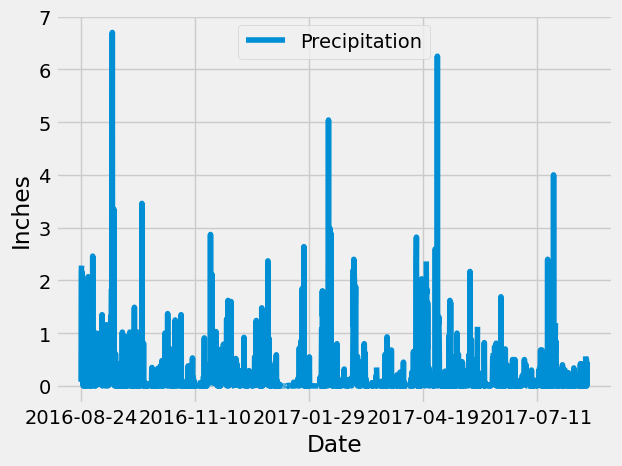

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(ylabel='Inches')
plt.show()


In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(s.id)).all()
station_count

[(9,)]

In [26]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(m.station, func.count(m.station)).\
    group_by(m.station).\
    order_by(func.count(m.station).desc()).\
    all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
most_active = session.query(m.station).\
                group_by(m.station).\
                order_by(func.count(m.station).desc()).\
                first()[0]
most_active

'USC00519281'

In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_data = session.query(func.min(m.tobs), func.max(m.tobs), func.avg(m.tobs)).\
                        filter(m.station == most_active).\
                        group_by(m.station).\
                        all()
most_active_data

[(54.0, 85.0, 71.66378066378067)]

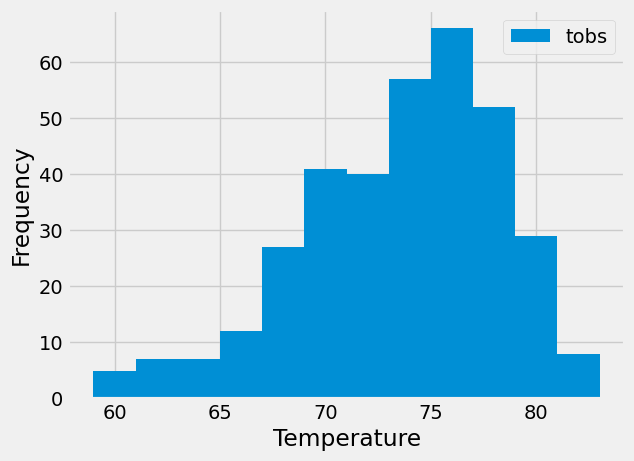

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_mon = session.query(m.tobs).\
                    filter(m.station == most_active).\
                    filter(m.date > year_ago).\
                    all()

last_12_mon_df = pd.DataFrame(last_12_mon)

last_12_mon_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.show()

# Close Session

In [47]:
# Close Session
session.close()